In [1]:
#pip
!pip install torchvision

In [2]:
# Imports
import pandas as pd
import os
import numpy as np
from numpy.distutils.misc_util import is_sequence
from bs4 import BeautifulSoup #this is to extract info from the xml, if we use it in the end
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
import json
import pickle

import torchvision
from torchvision import transforms, datasets, models
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import torch.optim as optim
from torch.utils.data.sampler import SubsetRandomSampler 
from sklearn.metrics import f1_score, precision_score, recall_score
import statistics 

import os
from datetime import datetime 
from pathlib import Path 


In [3]:
local_mode = False 
if local_mode:
    batch_size = 75
    num_epochs = 2
    epoch_partial_num = 1
    selfcsv_df = pd.read_csv("frame_MasterList.csv").head(900)  
    dir_path = os.getcwd()
else:
    batch_size = 128
    num_epochs = 100
    epoch_partial_num = 100
    selfcsv_df = pd.read_csv("frame_MasterList.csv")
    dir_path = "/scratch/na3au/modelRuns"

In [4]:
try:
    current_time = datetime.now().strftime("%Y_%m_%d-%I_%M_%S_%p") 
    directory = dir_path+"/"+current_time+"_NOTEBOOK"
    if not os.path.exists(directory):
        os.makedirs(directory)
    print(f'Creation of directory at {directory} successful')
except:
    print(f'Creation of directory at {directory} failed')


Creation of directory at /Users/navya/Desktop/Capstone/thermal-pedestrian-detection-lstm/2020_12_28-12_30_38_PM_NOTEBOOK successful


In [5]:
file_output_path = directory+"/"

In [6]:
# Get label and encode
def get_box(obj):
    xmin = float(obj.find('xmin').text)
    xmax = float(obj.find('xmax').text)
    ymin = float(obj.find('ymin').text)
    ymax = float(obj.find('ymax').text)
    return [xmin, ymin, xmax, ymax]

def get_label(obj):
    if obj.find('name').text == 'person' or obj.find('name').text == 'people':
        return 1
    if obj.find('name').text == 'cyclist':
        return 2
    else:
        return 0

# Generate the target location in the image
def generate_target(image_id,file):
    with open(file) as f:
        data = f.read()
        soup = BeautifulSoup(data, 'xml') #probably will have to change this
        objects = soup.find_all('object')

        num_objs = len(objects)

        boxes = []
        labels = []

        for i in objects:
            boxes.append(get_box(i))
            labels.append(get_label(i))
            
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.as_tensor(labels, dtype=torch.int64)
        img_id = torch.tensor([image_id])

        # Creating the target for the box
        target={}
        target['boxes'] = boxes
        target['labels'] = labels
        target['image_id'] = img_id

        return target

def OHE(label):
  if label == "People" or label== "Person":
      return 1
  elif label == "Cyclist":
      return 2
  else:
      return 0

def Recode(label):
  if label == 1:
      return "Person(s)"
  elif label == 2:
      return "Cyclist"
  else:
      return "N/A"

class FullImages(object):
    def __init__(self, transforms=None):
        self.csv = selfcsv_df
        self.csv_len = self.csv.shape[1]
        self.imgs = self.csv.image_path.tolist()
        self.imgs_len = len(self.imgs)
        self.transforms = transforms

    def __len__(self):
        return self.imgs_len
        #return self.csv_len

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img = self.csv.loc[idx, 'image_path']
        annotation = self.csv.loc[idx, 'annotation_path']

        img = Image.open(img).convert("L")
        target = generate_target(idx, annotation)

        # label = self.labels[idx]
        # label = OHE(label)
        # label = torch.as_tensor(label, dtype=torch.int64)

        if self.transforms is not None:
            img = self.transforms(img)

        return img, target


In [7]:
# Normalize
data_transform = transforms.Compose([#transforms.Resize((80,50)),
                                     transforms.ToTensor(),
                                     transforms.Normalize([0.5], [0.5]
                                                          )])

# Collate images
def collate_fn(batch):
    return tuple(zip(*batch)) #will need adjusting when pathing is adjusted

dataset = FullImages(data_transform)
data_size = len(dataset)
print(f'Length of Dataset: {data_size}')

indices = list(range(data_size))
test_split = 0.2
split = int(np.floor(test_split * data_size))
#print(f'Length of Split Dataset: {split}')

train_indices, test_indices = indices[split:], indices[:split]
len_train_ind, len_test_ind = len(train_indices), len(test_indices)
print(f'Length of Train: {len_train_ind}; Length of Test: {len_test_ind}')


Length of Dataset: 900
Length of Train: 720; Length of Test: 180


In [8]:

train_sampler = SubsetRandomSampler(train_indices)
test_sampler = SubsetRandomSampler(test_indices)

data_loader = torch.utils.data.DataLoader(
    dataset,
    batch_size = batch_size,
    sampler = train_sampler,
    collate_fn = collate_fn
)

len_dataloader = len(data_loader)
print(f'Length of train: {len_dataloader}')

data_loader_test = torch.utils.data.DataLoader(dataset, batch_size=batch_size, sampler = test_sampler, collate_fn = collate_fn)
len_testdataloader = len(data_loader_test)
print(f'Length of test: {len_testdataloader}')


Length of train: 10
Length of test: 3


In [9]:
# Check if GPU
cuda = torch.cuda.is_available()
if cuda:
    device = torch.device("cuda")
    print(f'CUDA device')
else:
    device = torch.device("cpu")
    print(f'CPU device')

# Instance segmentation is crucial in using the full images
def get_model_instance_segmentation(num_classes):
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained = True)
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(
        in_features, num_classes)
    return model


CPU device


In [10]:
for test_imgs, test_annotations in data_loader_test:
    imgs_test = list(img_test.to(device) for img_test in test_imgs)
    annotations_test = [{k: v.to(device) for k, v in t.items()} for t in test_annotations]

for train_imgs, train_annotations in data_loader:
    imgs_train = list(img_train.to(device) for img_train in train_imgs)
    annotations_train = [{k: v.to(device) for k, v in t.items()} for t in train_annotations]
    
print(f'{len_testdataloader} batches in test data loader.')
print(f'{len_dataloader} batches in test data loader.')


3 batches in test data loader.
10 batches in test data loader.


In [11]:
test_annotations_list = []
for dictionary in test_annotations:
  annotation = dictionary['image_id']
  test_annotations_list.append(annotation)
  
train_annotations_list = []
for dictionary in train_annotations:
  annotation = dictionary['image_id']
  train_annotations_list.append(annotation)
  
print(f'{len(test_annotations_list)} unique image ids in test annotations')
print(f'{len(train_annotations_list)} unique image ids in train annotations')

30 unique image ids in test annotations
45 unique image ids in train annotations


In [13]:
#cnn = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained = False)
model = get_model_instance_segmentation(3)
model.to(device)
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.Adam(params) #, lr = 0.005, weight_decay = 0.0005)

In [14]:

tot_ats = 0
epochs = 0
epoch_ats = []
epoch_losses = []
df = pd.DataFrame({'Mean_Epoch_Loss': epoch_losses}) 
for epoch in range(num_epochs):
    epochs += 1
    print(f'Epoch: {epochs}')
    model.train()
    epoch_loss = 0
    i = 0
    for train_imgs, train_annotations in data_loader:
        imgs = list(img.to(device) for img in train_imgs)
        annotations = [{k: v.to(device) for k, v in t.items()} for t in train_annotations]
        loss_dict = model([imgs[0]], [annotations[0]])
        losses = sum(loss for loss in loss_dict.values())
        
        optimizer.zero_grad()
        losses.backward()
        optimizer.step()
        
        i += 1
        tot_ats += 1 
    
        epoch_loss += losses
        print(f'Iteration: {i}/{len_dataloader}, Loss: {losses}')
        
    
    mean_epoch_loss = epoch_loss/i
    epoch_losses.append(mean_epoch_loss)
    epoch_ats.append(i)
    
    if epochs % epoch_partial_num == 0:
        df = pd.DataFrame({'Mean_Epoch_Loss': epoch_losses})  
        #print(df)
        partial_name = "full_model_partial_" + str(epochs)     
        df.to_csv(file_output_path+partial_name+ "_losses.csv", index=False)
        torch.save(model.state_dict(), file_output_path+partial_name + ".pt") 
        print(f'Partial model and losses for epoch {file_output_path} saved to {directory}.')    
        
    # Update learning rate
    #lr_scheduler.step()

try:
    # Save training metrics
    full_name = "full_model_losses_" + str(epochs) + ".csv"
    df.to_csv(file_output_path+full_name, index=False)
    print(f'Full model losses for {epochs} epochs saved to {directory}.') 
except:
    pass

try:
    # Save model
    torch.save(model.state_dict(), file_output_path+'full_model.pt')
    print(f'Full model trained on {epochs} epochs saved to {directory}.')     
except:
    pass

print(f'Annotations Trained: {tot_ats}')

# model2 = get_model_instance_segmentation(3)
# model2.load_state_dict(torch.load(file_output_path+'full_model.pt'))
# model2.eval()
# model2.to(device)


Epoch: 1


Iteration: 1/10, Loss: 1.3654053211212158


Iteration: 2/10, Loss: 2.0933034420013428


Iteration: 3/10, Loss: 2.83834171295166


Iteration: 4/10, Loss: 4.319192409515381


Iteration: 5/10, Loss: 2.078707456588745


Iteration: 6/10, Loss: 1.020268201828003


Iteration: 7/10, Loss: 1.3290528059005737


Iteration: 8/10, Loss: 0.32242897152900696


Iteration: 9/10, Loss: 0.5671406388282776


Iteration: 10/10, Loss: 0.4395231604576111


Partial model and losses for epoch /Users/navya/Desktop/Capstone/thermal-pedestrian-detection-lstm/2020_12_28-12_30_38_PM_NOTEBOOK/ saved to /Users/navya/Desktop/Capstone/thermal-pedestrian-detection-lstm/2020_12_28-12_30_38_PM_NOTEBOOK.
Epoch: 2


Iteration: 1/10, Loss: 0.373548686504364


Iteration: 2/10, Loss: 0.4247315526008606


Iteration: 3/10, Loss: 3.357313871383667


Iteration: 4/10, Loss: 0.45006391406059265


Iteration: 5/10, Loss: 2.4644887447357178


Iteration: 6/10, Loss: 0.15578775107860565


Iteration: 7/10, Loss: 1.8668664693832397


Iteration: 8/10, Loss: 0.2689846158027649


Iteration: 9/10, Loss: 0.5370380878448486


Iteration: 10/10, Loss: 0.1868358701467514


Partial model and losses for epoch /Users/navya/Desktop/Capstone/thermal-pedestrian-detection-lstm/2020_12_28-12_30_38_PM_NOTEBOOK/ saved to /Users/navya/Desktop/Capstone/thermal-pedestrian-detection-lstm/2020_12_28-12_30_38_PM_NOTEBOOK.
Full model losses for 2 epochs saved to /Users/navya/Desktop/Capstone/thermal-pedestrian-detection-lstm/2020_12_28-12_30_38_PM_NOTEBOOK.
Full model trained on 2 epochs saved to /Users/navya/Desktop/Capstone/thermal-pedestrian-detection-lstm/2020_12_28-12_30_38_PM_NOTEBOOK.
Annotations Trained: 20


In [ ]:
epoch_ats


In [26]:
# CASE 1: model is on  GPU, but  data is on CPU. SOLUTION: send input tensors to GPU.
train_imgs = [t.to(device) for t in train_imgs]
test_imgs = [t.to(device) for t in test_imgs]
    
train_annotations = [{'boxes':d['boxes'].to(device),'labels':d['labels'].to(device), 'image_id':d['image_id'].to(device)} for d in train_annotations]
test_annotations = [{'boxes':d['boxes'].to(device),'labels':d['labels'].to(device), 'image_id':d['image_id'].to(device)} for d in test_annotations]



In [27]:
test_annotations_list = []
for dictionary in test_annotations:
  annotation = dictionary['image_id']
  test_annotations_list.append(annotation)
  
train_annotations_list = []
for dictionary in train_annotations:
  annotation = dictionary['image_id']
  train_annotations_list.append(annotation)
  
print(f'{len(test_annotations_list)} unique image ids in test annotations')
print(f'{len(train_annotations_list)} unique image ids in train annotations')

30 unique image ids in test annotations
45 unique image ids in train annotations


In [28]:
master_csv = pd.read_csv("frame_MasterList.csv")
model.eval()

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256)
          (relu): ReLU(inplace=True)
          (downsample)

In [29]:
preds_train = model(train_imgs)
print(len(preds_train))
print(preds_train)


45


[{'boxes': tensor([[9.1952e+01, 1.3400e+02, 1.4884e+02, 2.9009e+02],
        [5.1226e+01, 1.0349e+02, 1.0782e+02, 2.5920e+02],
        [7.1546e+01, 1.3403e+02, 1.2829e+02, 2.9010e+02],
        [1.1250e+02, 1.3412e+02, 1.6929e+02, 2.9005e+02],
        [6.1482e+01, 1.7526e+02, 1.1799e+02, 3.3106e+02],
        [4.0960e+01, 1.4444e+02, 9.7528e+01, 3.0017e+02],
        [1.0246e+02, 1.7520e+02, 1.5894e+02, 3.3109e+02],
        [8.1995e+01, 1.8538e+02, 1.3844e+02, 3.4128e+02],
        [1.3313e+02, 1.3439e+02, 1.8972e+02, 2.8990e+02],
        [8.1999e+01, 9.3610e+01, 1.3855e+02, 2.4884e+02],
        [1.2298e+02, 1.7528e+02, 1.7940e+02, 3.3097e+02],
        [3.0809e+01, 8.3260e+01, 8.7337e+01, 2.3861e+02],
        [2.0656e+01, 1.1350e+02, 7.6885e+01, 2.6957e+02],
        [2.0624e+01, 1.8537e+02, 7.6871e+01, 3.4136e+02],
        [1.5378e+02, 1.3497e+02, 2.1019e+02, 2.8963e+02],
        [2.0699e+01, 2.8795e+02, 7.6888e+01, 4.4344e+02],
        [1.0413e+01, 6.2561e+01, 6.6505e+01, 2.1856e+02],
   

In [30]:
preds_test = model(test_imgs)
print(len(preds_test))
print(preds_test)


30


[{'boxes': tensor([[4.8130e+02, 2.3586e+02, 5.3778e+02, 3.9304e+02],
        [5.0175e+02, 2.1574e+02, 5.5830e+02, 3.7239e+02],
        [4.2986e+02, 1.3355e+02, 4.8660e+02, 2.9071e+02],
        [3.0577e+01, 1.6441e+02, 8.7271e+01, 3.2127e+02],
        [4.5046e+02, 1.1311e+02, 5.0708e+02, 2.7000e+02],
        [5.1149e+01, 1.6456e+02, 1.0771e+02, 3.2120e+02],
        [5.2227e+02, 2.1594e+02, 5.7880e+02, 3.7216e+02],
        [4.1979e+02, 2.0565e+02, 4.7639e+02, 3.6195e+02],
        [4.0946e+02, 1.6439e+02, 4.6622e+02, 3.2101e+02],
        [1.1279e+02, 1.9551e+02, 1.6923e+02, 3.5153e+02],
        [1.0219e+02, 1.5438e+02, 1.5892e+02, 3.1102e+02],
        [5.3226e+02, 1.7492e+02, 5.8909e+02, 3.3118e+02],
        [2.0617e+01, 2.1543e+02, 7.6949e+01, 3.7214e+02],
        [8.1645e+01, 1.3353e+02, 1.3840e+02, 2.9062e+02],
        [1.7413e+02, 1.8536e+02, 2.3075e+02, 3.4109e+02],
        [1.0117e+01, 1.7403e+02, 6.6578e+01, 3.3188e+02],
        [4.3137e+02, 2.1445e+02, 6.1979e+02, 3.2697e+02],
   

In [31]:

len(annotations)


45

In [32]:

len(test_annotations)

30

In [33]:
if preds_train == preds_test:
    print(f'Train predictions EQUAL test predictions.')
else:
    print(f'Train predictions DO NOT EQUAL test predictions.')

Train predictions DO NOT EQUAL test predictions.


In [34]:
def get_iou(num, input, test = False):
    if test:
        identifier = "Test"
        annotation = annotations_test[num]
        prediction = preds_test[num]
    else:
        identifier = "Train"
        annotation = annotations[num]
        prediction = preds_train[num]
    
    annotation_boxes = annotation["boxes"].tolist()
    
    ix = 0
    for box in annotation["boxes"]:
        img_id = annotation["image_id"].item()
        file_name = master_csv.loc[img_id,:].image_path
        set = file_name.split("/")[7]
        video = file_name.split("/")[8]
        file_name = file_name.split("/")[10]
        file_name = file_name[:-4]
        output_name = set+"_"+video+"_"+file_name
        ix += 1  

    ix = 0
    voc_iou = []
    print(f'{len(prediction["boxes"])} prediction boxes made for {len(annotation["boxes"])} actual boxes in {str(output_name)} for {identifier} with note {input}')
    for box in prediction["boxes"]:
        xmin, ymin, xmax, ymax = box.tolist()
        iou_list = []
        for bound in annotation_boxes:
            a_xmin, a_ymin, a_xmax, a_ymax = bound
            xA = max(xmin, a_xmin)
            yA = max(ymin, a_ymin)
            xB = min(xmax, a_xmax)
            yB = min(ymax, a_ymax)
            interArea = max(0, xB - xA + 1) * max(0, yB - yA + 1)
            p_area = (xmax - xmin + 1) * (ymax - ymin + 1)
            a_area = (a_xmax - a_xmin + 1) * (a_ymax - a_ymin + 1)
            iou = interArea / float(p_area + a_area - interArea)
            iou_list.append(iou)
        max_val = max(iou_list) 
        voc_iou.append(max_val)
        ix += 1
        
    if len(voc_iou) == 0:
        mean_iou = 0
        print(f'No predictions made so Mean IOU: {mean_iou}')
    else:
        mean_iou = sum(voc_iou)/len(voc_iou)
    
    return [mean_iou, voc_iou]

def plot_images(num, input):
    fig, ax = plt.subplots(nrows=1, ncols=2)
    img_tensor = imgs[num]
    annotation = annotations[num]
    # for key, value in annotation.items():
    #         print(key, value)
    prediction = preds_train[num]
    
    img = img_tensor.cpu().data
    img = img[0,:,:]
    
    ax[0].imshow(img, cmap='gray')
    ax[1].imshow(img, cmap='gray')
    
    ix = 0
    for box in annotation["boxes"]:
        #print(annotations[ix])
        xmin, ymin, xmax, ymax = box.tolist()
        value = annotation["labels"][ix]
        img_id = annotation["image_id"].item()
        file_name = master_csv.loc[img_id,:].image_path
        set = file_name.split("/")[7]
        video = file_name.split("/")[8]
        file_name = file_name.split("/")[10]
        file_name = file_name[:-4]
        output_name = set+"_"+video+"_"+file_name
        text = Recode(value)
        colors = ["r", "#00FF00",  "#0000FF"]
        rect = patches.Rectangle((xmin, ymin), (xmax - xmin), (ymax - ymin), linewidth=1,
                                 edgecolor=colors[value], facecolor='none')
        target_x = xmin
        target_y = ymin - 5
        ax[0].text(target_x, target_y, text, color=colors[value])
        ax[0].add_patch(rect)
        ix += 1
        

    ix = 0
    print(str(len(prediction["boxes"])) + " prediction boxes made for " + str(len(annotation["boxes"])) + " actual boxes in " + str(output_name))
    for box in prediction["boxes"]:
        xmin, ymin, xmax, ymax = box.tolist()
        value = prediction["labels"][ix]
        text = Recode(value)
        colors = ["r", "#00FF00",  "#0000FF"]
        rect = patches.Rectangle((xmin, ymin), (xmax - xmin), (ymax - ymin), linewidth=1,
                                 edgecolor=colors[value], facecolor='none')
        target_x = xmin
        target_y = ymin - 5
        ax[1].text(target_x, target_y, text, color=colors[value])
        ax[1].add_patch(rect)
        ix += 1
        
    #figname = file_name+"_"+input+".png"
    #fig.savefig(figname)
    plt.show()
    
# A predicted bounding box is considered correct if it overlaps more than 50% with a ground-truth bounding box, otherwise the bounding box is considered a false positive detection. Multiple detections are penalized. If a system predicts several bounding boxes that overlap with a single ground-truth bounding box, only one prediction is considered correct, the others are considered false positives.

### AFTER INTERIM: 
# Use get_iou to store set, video, frame, annotation boxes, pred boxes, lists of iou
# Dictionary like {cyclist: [IOU, IOU, IOU], people: [IOU, IOU]}

def plot_iou(num, input, test = False):
    fig, ax = plt.subplots(1)
    if test:
        identifier = "Test" 
        print(identifier)
        img_tensor = imgs_test[num]
        annotation = annotations_test[num]
        prediction = preds_test[num]
    else:
        identifier = "Train" 
        print(identifier)
        img_tensor = imgs[num]
        annotation = annotations[num]
        prediction = preds_train[num]
    
    img = img_tensor.cpu().data
    img = img[0,:,:]
    annotation_boxes = annotation["boxes"].tolist()  
    
    ax.imshow(img, cmap='gray')
    
    ix = 0
    for box in annotation["boxes"]:
        xmin, ymin, xmax, ymax = box.tolist()
        value = annotation["labels"][ix]
        img_id = annotation["image_id"].item()
        file_name = master_csv.loc[img_id,:].image_path
        set = file_name.split("/")[7]
        video = file_name.split("/")[8]
        file_name = file_name.split("/")[10]
        file_name = file_name[:-4]
        output_name = set+"_"+video+"_"+file_name+"_"+identifier
        text = Recode(value)
        colors = ["r", "r", "r"]
        rect = patches.Rectangle((xmin, ymin), (xmax - xmin), (ymax - ymin), linewidth=1,
                                 edgecolor=colors[value], facecolor='none')
        target_x = xmin
        target_y = ymin - 5
        ax.text(target_x, target_y, text, color=colors[value])
        ax.add_patch(rect)
        ix += 1  

    ix = 0
    voc_iou = []
    print(f'{len(prediction["boxes"])} prediction boxes made for {len(annotation["boxes"])} actual boxes in {str(output_name)} for {identifier} with note {input} (INDEX {num})')
    for box in prediction["boxes"]:
        xmin, ymin, xmax, ymax = box.tolist()
        
        iou_list = []
        for bound in annotation_boxes:
            a_xmin, a_ymin, a_xmax, a_ymax = bound
            xA = max(xmin, a_xmin)
            yA = max(ymin, a_ymin)
            xB = min(xmax, a_xmax)
            yB = min(ymax, a_ymax)
            interArea = max(0, xB - xA + 1) * max(0, yB - yA + 1)
            p_area = (xmax - xmin + 1) * (ymax - ymin + 1)
            a_area = (a_xmax - a_xmin + 1) * (a_ymax - a_ymin + 1)
            iou = interArea / float(p_area + a_area - interArea)
            iou_list.append(iou)
        max_val = max(iou_list) 
        voc_iou.append(max_val)

        max_ix = iou_list.index(max_val)
        map_dict = {max_ix: max_val} 
        
        #iou_string = ', '.join((str(float) for float in iou_list))
        value = prediction["labels"][ix]
        text = json.dumps(map_dict)
        colors = ["r", "#00FF00",  "#0000FF"]
        rect = patches.Rectangle((xmin, ymin), (xmax - xmin), (ymax - ymin), linewidth=1,
                                 edgecolor=colors[value], facecolor='none')
        target_x = xmin
        target_y = ymin - 5
        ax.text(target_x, target_y, text, color=colors[value])
        ax.add_patch(rect)
        ix += 1
    
    plt.show()
    
    if len(voc_iou) == 0:
        mean_iou = 0
        print(f'No predictions made so Mean IOU: {mean_iou}')
    else:
        mean_iou = sum(voc_iou)/len(voc_iou)
        fp = voc_iou.count(0)/len(voc_iou) * 100
        bp = sum((i > 0 and i < 0.5) for i in voc_iou)/len(voc_iou) * 100
        gp = sum((i >= 0.5) for i in voc_iou)/len(voc_iou) * 100
        print(f'{fp} false positives (IOU = 0)') 
        print(f'{bp} bad positives (0 < IOU < 0.5)')
        print(f'{gp} good positives (IOU >= 0.5)')
        print(f'Mean IOU: {mean_iou}')

    figname = output_name+"_"+input+".png"
    fig.savefig(file_output_path+figname)
    print(f'Figure {figname} saved to {directory}.')  




In [35]:
print(f'Train is {len(preds_train)} and test is {len(preds_test)}')

Train is 45 and test is 30


100 prediction boxes made for 1 actual boxes in set01_V002_I00384


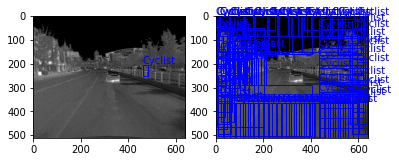

In [36]:
plot_images(0, "first")

Train
100 prediction boxes made for 1 actual boxes in set01_V002_I00384_Train for Train with note first (INDEX 0)


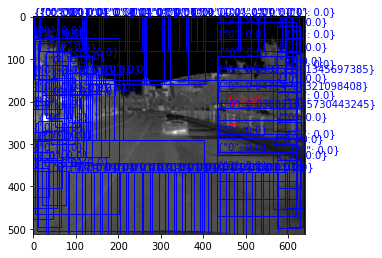

97.0 false positives (IOU = 0)
3.0 bad positives (0 < IOU < 0.5)
0.0 good positives (IOU >= 0.5)
Mean IOU: 0.001234751802871247


Figure set01_V002_I00384_Train_first.png saved to /Users/navya/Desktop/Capstone/thermal-pedestrian-detection-lstm/2020_12_28-12_30_38_PM_NOTEBOOK.
Train
100 prediction boxes made for 5 actual boxes in set01_V003_I00733_Train for Train with note last (INDEX 44)


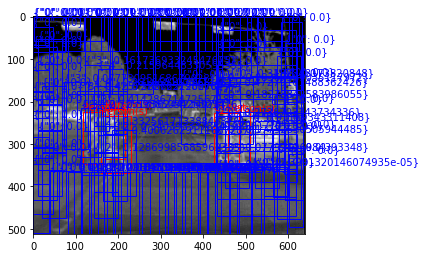

73.0 false positives (IOU = 0)
23.0 bad positives (0 < IOU < 0.5)
4.0 good positives (IOU >= 0.5)
Mean IOU: 0.06849058025982638


Figure set01_V003_I00733_Train_last.png saved to /Users/navya/Desktop/Capstone/thermal-pedestrian-detection-lstm/2020_12_28-12_30_38_PM_NOTEBOOK.


In [37]:
plot_iou(0, "first", False)
plot_iou(len(preds_train)-1, "last", False)

In [38]:

get_iou(len(preds_train)-1, "last", False)[0]

100 prediction boxes made for 5 actual boxes in set01_V003_I00733 for Train with note last


0.06849058025982638

Test
100 prediction boxes made for 3 actual boxes in set01_V003_I00657_Test for Test with note first (INDEX 0)


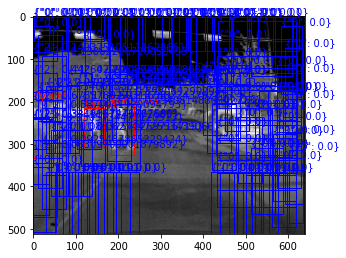

78.0 false positives (IOU = 0)
18.0 bad positives (0 < IOU < 0.5)
4.0 good positives (IOU >= 0.5)
Mean IOU: 0.06910061738429303


Figure set01_V003_I00657_Test_first.png saved to /Users/navya/Desktop/Capstone/thermal-pedestrian-detection-lstm/2020_12_28-12_30_38_PM_NOTEBOOK.
Test
100 prediction boxes made for 3 actual boxes in set01_V004_I01340_Test for Test with note last (INDEX 29)


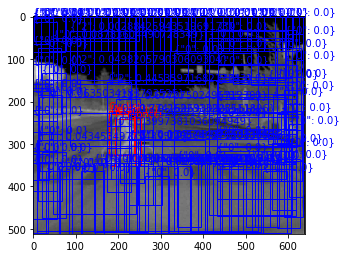

81.0 false positives (IOU = 0)
16.0 bad positives (0 < IOU < 0.5)
3.0 good positives (IOU >= 0.5)
Mean IOU: 0.035995208743475234


Figure set01_V004_I01340_Test_last.png saved to /Users/navya/Desktop/Capstone/thermal-pedestrian-detection-lstm/2020_12_28-12_30_38_PM_NOTEBOOK.


In [39]:
plot_iou(0, "first", True)
plot_iou(len(preds_test)-1, "last", True)

In [41]:
get_iou(len(preds_test)-1, "last", True)[0]


100 prediction boxes made for 3 actual boxes in set01_V004_I01340 for Test with note last


0.035995208743475234

In [42]:
iou_df_train = pd.DataFrame(columns=["Train_Mean_IOU", "IOU_List"])
for train_pred in range(0, len(preds_train)):
    iou_function = get_iou(train_pred, "first", False)
    len_df = len(iou_df_train)
    iou_df_train.loc[len_df,:] = iou_function
    try:
        if train_pred % 50 == 0:
            partial_name = "partial_iou_TRAIN_" + str(train_pred) + "_images.csv" 
            iou_df_train.to_csv(file_output_path+partial_name, index=False)
            print(f'Partial train IOUs for {len(iou_df_train)} images saved to {directory}.') 
    except:
        pass
        
iou_df_train_name = "full_iou_TRAIN_" + str(epochs) + ".csv"
iou_df_train.to_csv(file_output_path+iou_df_train_name, index=False)
print(f'Full train IOUs for {len(iou_df_train)} images saved to {directory}.') 


100 prediction boxes made for 1 actual boxes in set01_V002_I00384 for Train with note first
Partial train IOUs for 1 images saved to /Users/navya/Desktop/Capstone/thermal-pedestrian-detection-lstm/2020_12_28-12_30_38_PM_NOTEBOOK.
100 prediction boxes made for 4 actual boxes in set01_V003_I00600 for Train with note first
100 prediction boxes made for 1 actual boxes in set01_V004_I00276 for Train with note first
100 prediction boxes made for 3 actual boxes in set01_V004_I01361 for Train with note first
100 prediction boxes made for 1 actual boxes in set01_V002_I00283 for Train with note first
100 prediction boxes made for 3 actual boxes in set01_V003_I00639 for Train with note first
100 prediction boxes made for 1 actual boxes in set01_V004_I00249 for Train with note first
100 prediction boxes made for 3 actual boxes in set01_V001_I00232 for Train with note first
100 prediction boxes made for 4 actual boxes in set01_V000_I01758 for Train with note first
100 prediction boxes made for 3 ac

100 prediction boxes made for 4 actual boxes in set01_V003_I00607 for Train with note first
100 prediction boxes made for 7 actual boxes in set01_V001_I00025 for Train with note first
100 prediction boxes made for 4 actual boxes in set01_V004_I01308 for Train with note first
100 prediction boxes made for 3 actual boxes in set01_V003_I00645 for Train with note first
100 prediction boxes made for 2 actual boxes in set01_V002_I01263 for Train with note first
100 prediction boxes made for 7 actual boxes in set01_V001_I00706 for Train with note first
100 prediction boxes made for 6 actual boxes in set01_V000_I01783 for Train with note first
100 prediction boxes made for 5 actual boxes in set01_V003_I00757 for Train with note first
100 prediction boxes made for 5 actual boxes in set01_V003_I00747 for Train with note first
100 prediction boxes made for 4 actual boxes in set01_V003_I00622 for Train with note first
100 prediction boxes made for 4 actual boxes in set01_V003_I00607 for Train with

100 prediction boxes made for 2 actual boxes in set01_V002_I01257 for Train with note first
100 prediction boxes made for 3 actual boxes in set01_V003_I00631 for Train with note first
100 prediction boxes made for 3 actual boxes in set01_V003_I00855 for Train with note first
100 prediction boxes made for 1 actual boxes in set01_V002_I00662 for Train with note first
100 prediction boxes made for 2 actual boxes in set01_V003_I00687 for Train with note first
100 prediction boxes made for 1 actual boxes in set01_V005_I00105 for Train with note first
100 prediction boxes made for 3 actual boxes in set01_V001_I00187 for Train with note first
100 prediction boxes made for 5 actual boxes in set01_V003_I00733 for Train with note first
Full train IOUs for 45 images saved to /Users/navya/Desktop/Capstone/thermal-pedestrian-detection-lstm/2020_12_28-12_30_38_PM_NOTEBOOK.


In [43]:
print(iou_df_train.sort_values(by='Train_Mean_IOU', ascending=False).head(5))

   Train_Mean_IOU                                           IOU_List
36      0.0897347  [0.5351703537045671, 0.5715738847263059, 0.0, ...
8        0.082173  [0.2226408620774094, 0.0, 0.41816742098549714,...
28      0.0775788  [0.0, 0.4532761345684509, 0.45526645396879184,...
27      0.0769536  [0.0, 0.14413386545390777, 0.0, 0.065244058421...
29      0.0748308  [0.1834305824196027, 0.17323510494042874, 0.41...


In [44]:
iou_df_test = pd.DataFrame(columns=["Test_Mean_IOU", "IOU_List"])
for test_pred in range(0, len_testdataloader):
    iou_function = get_iou(test_pred, "test", False)
    len_df = len(iou_df_test)
    iou_df_test.loc[len_df,:] = iou_function
    try:
        if test_pred % 50 == 0:
            partial_name = "partial_iou_TEST_" + str(test_pred) + "_images.csv" 
            iou_df_test.to_csv(file_output_path+partial_name, index=False)
            print(f'Partial train IOUs for {len(iou_df_test)} images saved to {directory}.') 
    except:
        pass
        
iou_df_test_name = "full_iou_TEST_" + str(epochs) + ".csv"
iou_df_test.to_csv(file_output_path+iou_df_test_name, index=False)
print(f'Full train IOUs for {len(iou_df_test)} images saved to {directory}.') 


100 prediction boxes made for 1 actual boxes in set01_V002_I00384 for Train with note test
Partial train IOUs for 1 images saved to /Users/navya/Desktop/Capstone/thermal-pedestrian-detection-lstm/2020_12_28-12_30_38_PM_NOTEBOOK.
100 prediction boxes made for 4 actual boxes in set01_V003_I00600 for Train with note test
100 prediction boxes made for 1 actual boxes in set01_V004_I00276 for Train with note test
Full train IOUs for 3 images saved to /Users/navya/Desktop/Capstone/thermal-pedestrian-detection-lstm/2020_12_28-12_30_38_PM_NOTEBOOK.


In [45]:
print(iou_df_test.sort_values(by='Test_Mean_IOU', ascending=False).head(5))

  Test_Mean_IOU                                           IOU_List
1     0.0203896  [0.057439112986087865, 0.16406544890613547, 0....
2    0.00395313  [0.0, 0.0, 0.01994165807347384, 0.114392757196...
0    0.00123475  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...


In [46]:
max_train_ix = iou_df_train[iou_df_train['Train_Mean_IOU'] == iou_df_train['Train_Mean_IOU'].max()].index.tolist()[0]
max_test_ix = iou_df_test[iou_df_test['Test_Mean_IOU'] == iou_df_test['Test_Mean_IOU'].max()].index.tolist()[0]


In [47]:

max_train_ix

36

Train
100 prediction boxes made for 5 actual boxes in set01_V003_I00708_Train for Train with note best (INDEX 36)


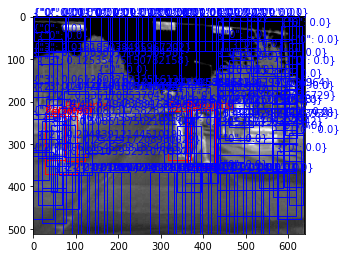

71.0 false positives (IOU = 0)
20.0 bad positives (0 < IOU < 0.5)
9.0 good positives (IOU >= 0.5)
Mean IOU: 0.08973472075418916


Figure set01_V003_I00708_Train_best.png saved to /Users/navya/Desktop/Capstone/thermal-pedestrian-detection-lstm/2020_12_28-12_30_38_PM_NOTEBOOK.


In [48]:
plot_iou(max_train_ix, "best", False)


Test
100 prediction boxes made for 3 actual boxes in set01_V001_I00185_Test for Test with note best (INDEX 1)


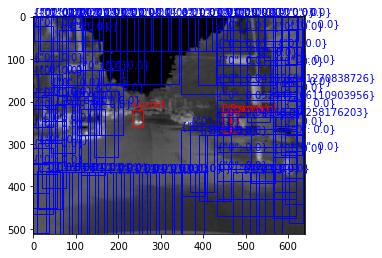

97.0 false positives (IOU = 0)
3.0 bad positives (0 < IOU < 0.5)
0.0 good positives (IOU >= 0.5)
Mean IOU: 0.0013588870996350472


Figure set01_V001_I00185_Test_best.png saved to /Users/navya/Desktop/Capstone/thermal-pedestrian-detection-lstm/2020_12_28-12_30_38_PM_NOTEBOOK.


In [49]:
plot_iou(max_test_ix, "best", True)


In [50]:
print(f'Train Mean IOU: {iou_df_train["Train_Mean_IOU"].mean()}')
print(f'Test Mean IOU: {iou_df_test["Test_Mean_IOU"].mean()}')

Train Mean IOU: 0.029788138643469426
Test Mean IOU: 0.008525817547145478
